In [1]:
pip install emoji

In [2]:
import numpy as np
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import lightgbm as lgb
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline
import matplotlib.pyplot as plt
import sklearn
from wordcloud import WordCloud

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [5]:
fdata = pd.read_csv('raw_compiled_tweets.csv')
fdata = fdata.drop('Unnamed: 0',axis = 1)
fdata.head()

,link,text,date,Likes,No_of_tweets
0,https://twitter.com/Zouqm22/status/1842949991993835826#m,Its half time in #LaLiga match #AlavésBarça Alavés 0-3 Barcelona. ⚽️ 7’: Lewandowski. (0-1) ⚽️ 22’: Lewandowski. (0-2) ⚽️ 32’: Lewandowski. (0-3) Lewandowski first half Hat-Trick is pure class #LALIGAEASPORTS #Barca #FCBarcelona,"Oct 6, 2024 · 3:28 PM UTC",12,0
1,https://twitter.com/ollsdav/status/1649145885878546442#m,So I visited the Spotify Camp Nou 😍 @BarcaUniversal @FCBarcelona #Campnou #Barca #FCB #Barcelona #Sportify,"Apr 20, 2023 · 8:19 PM UTC",2,0
2,https://twitter.com/SportsaholicOnX/status/1843397774982722022#m,"One of the greatest of all time, truly a legend. Enjoy Retirement! #iniesta #barca","Oct 7, 2024 · 9:07 PM UTC",0,0
3,https://twitter.com/voshans/status/1843375517577425027#m,In memoriam Johan & Johan #Cruijff #Cruyff #Neeskens #Ajax #Oranje #Barcelona #FCBarcelona #Barça #FCB,"Oct 7, 2024 · 7:39 PM UTC",18,1
4,https://twitter.com/LETFootball/status/1042202477117022208#m,The Johans #neeskens #cruyff #barca,"Sep 19, 2018 · 12:03 AM UTC",49,1


In [6]:
def classify_tweet_with_emoji(text):
    # Keywords for positive outcomes in match scorelines
    positive_keywords = ['win', 'victory', 'good', 'great', 'amazing', 'goal', 'praise', 'love', 'excellent', 'hatrick', ' top']

    # Keywords for negative outcomes in match scorelines
    negative_keywords = ['lose', 'loss', 'bad', 'poor', 'terrible', 'frustrated', 'worst', 'hate', 'disappoint', 'injury', 'injured']

    # Emoji classification as positive
    heart_emojis = ['❤️', '💙', '💜', '💖', '💗', '💓', '💕', '💞', '💘', '❣️','🔴','🔵','💪','👏','🔥']

    if any(emoji in text for emoji in heart_emojis):
        return 'positive'

    # Keywords related to scores, assuming any numbers mentioned are scorelines
    score_pattern = re.search(r'(\d+)-(\d+)', text)
    if score_pattern:
        score = re.findall(r'(\d+)-(\d+)', text)[0]
        if int(score[0]) > int(score[1]):
            return 'negative'  # Barca lost
        else:
            return 'positive'  # Barca won


    former_player_keywords = ['legend', 'cruyff', 'ronaldinho', 'messi', 'xavi', 'iniesta', 'puyol', 'johan', 'lionel']

    # Check if it's praise for former players
    if any(word in text for word in former_player_keywords):
        return 'neutral'

    # Check for positive sentiment
    if any(word in text for word in positive_keywords):
        return 'positive'

    # Check for negative sentiment
    elif any(word in text for word in negative_keywords):
        return 'negative'

    # Default to neutral if none of the above
    else:
        return 'neutral'

# Apply updated classification to the 'cleaned_text' column
fdata['classification'] = fdata['text'].apply(classify_tweet_with_emoji)

In [7]:
fdata.head()

,link,text,date,Likes,No_of_tweets,classification
0,https://twitter.com/Zouqm22/status/1842949991993835826#m,Its half time in #LaLiga match #AlavésBarça Alavés 0-3 Barcelona. ⚽️ 7’: Lewandowski. (0-1) ⚽️ 22’: Lewandowski. (0-2) ⚽️ 32’: Lewandowski. (0-3) Lewandowski first half Hat-Trick is pure class #LALIGAEASPORTS #Barca #FCBarcelona,"Oct 6, 2024 · 3:28 PM UTC",12,0,positive
1,https://twitter.com/ollsdav/status/1649145885878546442#m,So I visited the Spotify Camp Nou 😍 @BarcaUniversal @FCBarcelona #Campnou #Barca #FCB #Barcelona #Sportify,"Apr 20, 2023 · 8:19 PM UTC",2,0,neutral
2,https://twitter.com/SportsaholicOnX/status/1843397774982722022#m,"One of the greatest of all time, truly a legend. Enjoy Retirement! #iniesta #barca","Oct 7, 2024 · 9:07 PM UTC",0,0,neutral
3,https://twitter.com/voshans/status/1843375517577425027#m,In memoriam Johan & Johan #Cruijff #Cruyff #Neeskens #Ajax #Oranje #Barcelona #FCBarcelona #Barça #FCB,"Oct 7, 2024 · 7:39 PM UTC",18,1,neutral
4,https://twitter.com/LETFootball/status/1042202477117022208#m,The Johans #neeskens #cruyff #barca,"Sep 19, 2018 · 12:03 AM UTC",49,1,neutral


In [8]:
# Find frequencies of unique elements in the column
frequencies = fdata['classification'].value_counts()
print(frequencies)

classification
neutral     560
positive    351
negative     53
Name: count, dtype: int64


In [9]:
#For Classified Set - 1
print("Classified Set 1")

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X = tfidf.fit_transform(fdata['text']).toarray()

# Define the target variable
y = fdata['classification']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(fdata['classification'])  # Converts 'Negative', 'Neutral', 'Positive' to 0, 1, 2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=200)  # Set max_iter to avoid convergence warnings
lr_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test)

print("Logistic Regression Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

print("Multinomial Naive Bayes Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Support Vector Machines model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

print("Support Vector Machines Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

print("Random Forest Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("XGBoost Model")

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

print("LightBGM Model")

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classified Set 1
Logistic Regression Model
Accuracy: 0.7010309278350515
Confusion Matrix:
 [[ 0  5  3]
 [ 0 53  3]
 [ 0 18 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.70      0.95      0.80        56
           2       0.71      0.45      0.56        33

    accuracy                           0.70        97
   macro avg       0.47      0.47      0.45        97
weighted avg       0.65      0.70      0.65        97

Multinomial Naive Bayes Model
Accuracy: 0.6701030927835051
Confusion Matrix:
 [[ 0  5  3]
 [ 0 53  3]
 [ 0 21 12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      0.95      0.79        56
           2       0.67      0.36      0.47        33

    accuracy                           0.67        97
   macro avg       0.45      0.44      0.42        97
we

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Support Vector Machines Model
Accuracy: 0.7628865979381443
Confusion Matrix:
 [[ 1  5  2]
 [ 0 51  5]
 [ 0 11 22]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.76      0.91      0.83        56
           2       0.76      0.67      0.71        33

    accuracy                           0.76        97
   macro avg       0.84      0.57      0.59        97
weighted avg       0.78      0.76      0.74        97

Random Forest Model
Accuracy: 0.7010309278350515
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.69      0.93      0.79        56
           2       0.71      0.45      0.56        33

    accuracy                           0.70        97
   macro avg       0.80      0.50      0.52        97
weighted avg       0.73      0.70      0.67        97



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.7010309278350515
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.70      0.89      0.79        56
           2       0.68      0.52      0.59        33

    accuracy                           0.70        97
   macro avg       0.79      0.51      0.53        97
weighted avg       0.72      0.70      0.67        97

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3217
[LightGBM] [Info] Number of data points in the train set: 867, number of used features: 154
[LightGBM] [Info] Start training from score -2.958376
[LightGBM] [Info] Start training from score -0.542463
[LightGBM] [Info] Start training from score -1.002988
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightBGM Model
Accuracy: 0.7319587628865979
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.74      0.88      0.80        56
           2       0.70      0.64      0.67        33

    accuracy                           0.73        97
   macro avg       0.81      0.55      0.56        97
weighted avg       0.75      0.73      0.71        97



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
fdata2 = pd.read_csv('raw_compiled_tweets.csv')
fdata2 = fdata2.drop('Unnamed: 0',axis = 1)
fdata2.head()

,link,text,date,Likes,No_of_tweets
0,https://twitter.com/Zouqm22/status/1842949991993835826#m,Its half time in #LaLiga match #AlavésBarça Alavés 0-3 Barcelona. ⚽️ 7’: Lewandowski. (0-1) ⚽️ 22’: Lewandowski. (0-2) ⚽️ 32’: Lewandowski. (0-3) Lewandowski first half Hat-Trick is pure class #LALIGAEASPORTS #Barca #FCBarcelona,"Oct 6, 2024 · 3:28 PM UTC",12,0
1,https://twitter.com/ollsdav/status/1649145885878546442#m,So I visited the Spotify Camp Nou 😍 @BarcaUniversal @FCBarcelona #Campnou #Barca #FCB #Barcelona #Sportify,"Apr 20, 2023 · 8:19 PM UTC",2,0
2,https://twitter.com/SportsaholicOnX/status/1843397774982722022#m,"One of the greatest of all time, truly a legend. Enjoy Retirement! #iniesta #barca","Oct 7, 2024 · 9:07 PM UTC",0,0
3,https://twitter.com/voshans/status/1843375517577425027#m,In memoriam Johan & Johan #Cruijff #Cruyff #Neeskens #Ajax #Oranje #Barcelona #FCBarcelona #Barça #FCB,"Oct 7, 2024 · 7:39 PM UTC",18,1
4,https://twitter.com/LETFootball/status/1042202477117022208#m,The Johans #neeskens #cruyff #barca,"Sep 19, 2018 · 12:03 AM UTC",49,1


In [11]:
# Function to remove URLs, emojis, and special characters
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Remove user @ references and '#' from hashtags
    tweet = re.sub(r'\@\w+|\#', '', tweet)

    # Remove punctuations and numbers
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)

    # Remove emojis
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')

    # Convert to lowercase
    tweet = tweet.lower()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
    filtered_tweet = ' '.join([word for word in word_tokens if word not in stop_words])

    return filtered_tweet

# Apply the cleaning function to the text column
fdata2['cleaned_text'] = fdata2['text'].apply(clean_tweet)

In [12]:
fdata2.head()

,link,text,date,Likes,No_of_tweets,cleaned_text
0,https://twitter.com/Zouqm22/status/1842949991993835826#m,Its half time in #LaLiga match #AlavésBarça Alavés 0-3 Barcelona. ⚽️ 7’: Lewandowski. (0-1) ⚽️ 22’: Lewandowski. (0-2) ⚽️ 32’: Lewandowski. (0-3) Lewandowski first half Hat-Trick is pure class #LALIGAEASPORTS #Barca #FCBarcelona,"Oct 6, 2024 · 3:28 PM UTC",12,0,half time laliga match alavsbara alavs barcelona lewandowski lewandowski lewandowski lewandowski first half hattrick pure class laligaeasports barca fcbarcelona
1,https://twitter.com/ollsdav/status/1649145885878546442#m,So I visited the Spotify Camp Nou 😍 @BarcaUniversal @FCBarcelona #Campnou #Barca #FCB #Barcelona #Sportify,"Apr 20, 2023 · 8:19 PM UTC",2,0,visited spotify camp nou campnou barca fcb barcelona sportify
2,https://twitter.com/SportsaholicOnX/status/1843397774982722022#m,"One of the greatest of all time, truly a legend. Enjoy Retirement! #iniesta #barca","Oct 7, 2024 · 9:07 PM UTC",0,0,one greatest time truly legend enjoy retirement iniesta barca
3,https://twitter.com/voshans/status/1843375517577425027#m,In memoriam Johan & Johan #Cruijff #Cruyff #Neeskens #Ajax #Oranje #Barcelona #FCBarcelona #Barça #FCB,"Oct 7, 2024 · 7:39 PM UTC",18,1,memoriam johan johan cruijff cruyff neeskens ajax oranje barcelona fcbarcelona bara fcb
4,https://twitter.com/LETFootball/status/1042202477117022208#m,The Johans #neeskens #cruyff #barca,"Sep 19, 2018 · 12:03 AM UTC",49,1,johans neeskens cruyff barca


In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# Define a function to classify sentiments using VADER
def get_sentiment(tweet):
    score = sia.polarity_scores(tweet)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER sentiment analysis
fdata2['sentiment'] = fdata2['cleaned_text'].apply(get_sentiment)

In [14]:
fdata2.head()

,link,text,date,Likes,No_of_tweets,cleaned_text,sentiment
0,https://twitter.com/Zouqm22/status/1842949991993835826#m,Its half time in #LaLiga match #AlavésBarça Alavés 0-3 Barcelona. ⚽️ 7’: Lewandowski. (0-1) ⚽️ 22’: Lewandowski. (0-2) ⚽️ 32’: Lewandowski. (0-3) Lewandowski first half Hat-Trick is pure class #LALIGAEASPORTS #Barca #FCBarcelona,"Oct 6, 2024 · 3:28 PM UTC",12,0,half time laliga match alavsbara alavs barcelona lewandowski lewandowski lewandowski lewandowski first half hattrick pure class laligaeasports barca fcbarcelona,neutral
1,https://twitter.com/ollsdav/status/1649145885878546442#m,So I visited the Spotify Camp Nou 😍 @BarcaUniversal @FCBarcelona #Campnou #Barca #FCB #Barcelona #Sportify,"Apr 20, 2023 · 8:19 PM UTC",2,0,visited spotify camp nou campnou barca fcb barcelona sportify,neutral
2,https://twitter.com/SportsaholicOnX/status/1843397774982722022#m,"One of the greatest of all time, truly a legend. Enjoy Retirement! #iniesta #barca","Oct 7, 2024 · 9:07 PM UTC",0,0,one greatest time truly legend enjoy retirement iniesta barca,positive
3,https://twitter.com/voshans/status/1843375517577425027#m,In memoriam Johan & Johan #Cruijff #Cruyff #Neeskens #Ajax #Oranje #Barcelona #FCBarcelona #Barça #FCB,"Oct 7, 2024 · 7:39 PM UTC",18,1,memoriam johan johan cruijff cruyff neeskens ajax oranje barcelona fcbarcelona bara fcb,neutral
4,https://twitter.com/LETFootball/status/1042202477117022208#m,The Johans #neeskens #cruyff #barca,"Sep 19, 2018 · 12:03 AM UTC",49,1,johans neeskens cruyff barca,neutral


In [15]:
# Find frequencies of unique elements in the column
frequencies = fdata2['sentiment'].value_counts()
print(frequencies)

sentiment
positive    458
neutral     339
negative    167
Name: count, dtype: int64


In [16]:
#For Classified Set - 2
print("Classified Set 2")

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X = tfidf.fit_transform(fdata2['cleaned_text']).toarray()

# Define the target variable
y = fdata2['sentiment']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(fdata2['sentiment'])  # Converts 'Negative', 'Neutral', 'Positive' to 0, 1, 2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=200)  # Set max_iter to avoid convergence warnings
lr_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test)

print("Logistic Regression Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

print("Multinomial Naive Bayes Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Support Vector Machines model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

print("Support Vector Machines Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

print("Random Forest Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("XGBoost Model")

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

print("LightBGM Model")

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classified Set 2
Logistic Regression Model
Accuracy: 0.7216494845360825
Confusion Matrix:
 [[ 4  8 12]
 [ 1 27  5]
 [ 0  1 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.17      0.28        24
           1       0.75      0.82      0.78        33
           2       0.70      0.97      0.81        40

    accuracy                           0.72        97
   macro avg       0.75      0.65      0.62        97
weighted avg       0.74      0.72      0.67        97

Multinomial Naive Bayes Model
Accuracy: 0.5979381443298969
Confusion Matrix:
 [[ 2  2 20]
 [ 1 18 14]
 [ 0  2 38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.08      0.15        24
           1       0.82      0.55      0.65        33
           2       0.53      0.95      0.68        40

    accuracy                           0.60        97
   macro avg       0.67      0.53      0.49        97
we

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.6701030927835051
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.33      0.42        24
           1       0.63      0.73      0.68        33
           2       0.73      0.82      0.78        40

    accuracy                           0.67        97
   macro avg       0.65      0.63      0.62        97
weighted avg       0.66      0.67      0.65        97

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 867, number of used features: 85
[LightGBM] [Info] Start training from score -1.802194
[LightGBM] [Info] Start training from score -1.041454
[LightGBM] [Info] Start training from score -0.729558
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightBGM Model
Accuracy: 0.6494845360824743
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.42      0.50        24
           1       0.62      0.76      0.68        33
           2       0.68      0.70      0.69        40

    accuracy                           0.65        97
   macro avg       0.64      0.62      0.63        97
weighted avg       0.65      0.65      0.64        97



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
# Load a sentiment analysis pipeline with a pre-trained BERT model
classifier = pipeline('sentiment-analysis')

# Apply the classifier to each tweet
def bert_sentiment(tweet):
    result = classifier(tweet)[0]
    if result['label'] == 'POSITIVE':
        return 'positive'
    elif result['label'] == 'NEGATIVE':
        return 'negative'
    else:
        return 'neutral'

# Apply BERT sentiment classification
fdata2['sentiment'] = fdata2['cleaned_text'].apply(bert_sentiment)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


In [18]:
fdata2.head()

,link,text,date,Likes,No_of_tweets,cleaned_text,sentiment
0,https://twitter.com/Zouqm22/status/1842949991993835826#m,Its half time in #LaLiga match #AlavésBarça Alavés 0-3 Barcelona. ⚽️ 7’: Lewandowski. (0-1) ⚽️ 22’: Lewandowski. (0-2) ⚽️ 32’: Lewandowski. (0-3) Lewandowski first half Hat-Trick is pure class #LALIGAEASPORTS #Barca #FCBarcelona,"Oct 6, 2024 · 3:28 PM UTC",12,0,half time laliga match alavsbara alavs barcelona lewandowski lewandowski lewandowski lewandowski first half hattrick pure class laligaeasports barca fcbarcelona,positive
1,https://twitter.com/ollsdav/status/1649145885878546442#m,So I visited the Spotify Camp Nou 😍 @BarcaUniversal @FCBarcelona #Campnou #Barca #FCB #Barcelona #Sportify,"Apr 20, 2023 · 8:19 PM UTC",2,0,visited spotify camp nou campnou barca fcb barcelona sportify,positive
2,https://twitter.com/SportsaholicOnX/status/1843397774982722022#m,"One of the greatest of all time, truly a legend. Enjoy Retirement! #iniesta #barca","Oct 7, 2024 · 9:07 PM UTC",0,0,one greatest time truly legend enjoy retirement iniesta barca,positive
3,https://twitter.com/voshans/status/1843375517577425027#m,In memoriam Johan & Johan #Cruijff #Cruyff #Neeskens #Ajax #Oranje #Barcelona #FCBarcelona #Barça #FCB,"Oct 7, 2024 · 7:39 PM UTC",18,1,memoriam johan johan cruijff cruyff neeskens ajax oranje barcelona fcbarcelona bara fcb,positive
4,https://twitter.com/LETFootball/status/1042202477117022208#m,The Johans #neeskens #cruyff #barca,"Sep 19, 2018 · 12:03 AM UTC",49,1,johans neeskens cruyff barca,positive


In [19]:
# Find frequencies of unique elements in the column
frequencies = fdata2['sentiment'].value_counts()
print(frequencies)

sentiment
negative    485
positive    479
Name: count, dtype: int64


In [20]:
#For Classified Set - 3
print("Classified Set 3")

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X = tfidf.fit_transform(fdata2['cleaned_text']).toarray()

# Define the target variable
y = fdata2['sentiment']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(fdata2['sentiment'])  # Converts 'Negative', 'Neutral', 'Positive' to 0, 1, 2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=200)  # Set max_iter to avoid convergence warnings
lr_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test)

print("Logistic Regression Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

print("Multinomial Naive Bayes Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Support Vector Machines model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

print("Support Vector Machines Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

print("Random Forest Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("XGBoost Model")

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

print("LightBGM Model")

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classified Set 3
Logistic Regression Model
Accuracy: 0.7938144329896907
Confusion Matrix:
 [[39  9]
 [11 38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.80        48
           1       0.81      0.78      0.79        49

    accuracy                           0.79        97
   macro avg       0.79      0.79      0.79        97
weighted avg       0.79      0.79      0.79        97

Multinomial Naive Bayes Model
Accuracy: 0.8041237113402062
Confusion Matrix:
 [[35 13]
 [ 6 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.73      0.79        48
           1       0.77      0.88      0.82        49

    accuracy                           0.80        97
   macro avg       0.81      0.80      0.80        97
weighted avg       0.81      0.80      0.80        97

Support Vector Machines Model
Accuracy: 0.8144329896907216
Confusion Matrix:
 [[42  6]
 [12

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.7319587628865979
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.81      0.75        48
           1       0.78      0.65      0.71        49

    accuracy                           0.73        97
   macro avg       0.74      0.73      0.73        97
weighted avg       0.74      0.73      0.73        97

[LightGBM] [Info] Number of positive: 430, number of negative: 437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 867, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495963 -> initscore=-0.016148
[LightGBM] [Info] Start training from score -0.016148
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [21]:
from textblob import TextBlob

def textblob_sentiment(tweet):
    analysis = TextBlob(tweet)
    # Categorize polarity score into positive, neutral, or negative
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply TextBlob sentiment classification
fdata2['sentiment'] = fdata2['cleaned_text'].apply(textblob_sentiment)

In [22]:
fdata2.head()

,link,text,date,Likes,No_of_tweets,cleaned_text,sentiment
0,https://twitter.com/Zouqm22/status/1842949991993835826#m,Its half time in #LaLiga match #AlavésBarça Alavés 0-3 Barcelona. ⚽️ 7’: Lewandowski. (0-1) ⚽️ 22’: Lewandowski. (0-2) ⚽️ 32’: Lewandowski. (0-3) Lewandowski first half Hat-Trick is pure class #LALIGAEASPORTS #Barca #FCBarcelona,"Oct 6, 2024 · 3:28 PM UTC",12,0,half time laliga match alavsbara alavs barcelona lewandowski lewandowski lewandowski lewandowski first half hattrick pure class laligaeasports barca fcbarcelona,positive
1,https://twitter.com/ollsdav/status/1649145885878546442#m,So I visited the Spotify Camp Nou 😍 @BarcaUniversal @FCBarcelona #Campnou #Barca #FCB #Barcelona #Sportify,"Apr 20, 2023 · 8:19 PM UTC",2,0,visited spotify camp nou campnou barca fcb barcelona sportify,neutral
2,https://twitter.com/SportsaholicOnX/status/1843397774982722022#m,"One of the greatest of all time, truly a legend. Enjoy Retirement! #iniesta #barca","Oct 7, 2024 · 9:07 PM UTC",0,0,one greatest time truly legend enjoy retirement iniesta barca,positive
3,https://twitter.com/voshans/status/1843375517577425027#m,In memoriam Johan & Johan #Cruijff #Cruyff #Neeskens #Ajax #Oranje #Barcelona #FCBarcelona #Barça #FCB,"Oct 7, 2024 · 7:39 PM UTC",18,1,memoriam johan johan cruijff cruyff neeskens ajax oranje barcelona fcbarcelona bara fcb,neutral
4,https://twitter.com/LETFootball/status/1042202477117022208#m,The Johans #neeskens #cruyff #barca,"Sep 19, 2018 · 12:03 AM UTC",49,1,johans neeskens cruyff barca,neutral


In [23]:
#For Classified Set - 4
print("Classified Set 4")

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X = tfidf.fit_transform(fdata2['cleaned_text']).toarray()

# Define the target variable
y = fdata2['sentiment']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(fdata2['sentiment'])  # Converts 'Negative', 'Neutral', 'Positive' to 0, 1, 2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=200)  # Set max_iter to avoid convergence warnings
lr_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test)

print("Logistic Regression Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

print("Multinomial Naive Bayes Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Support Vector Machines model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

print("Support Vector Machines Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

print("Random Forest Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("XGBoost Model")

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

print("LightBGM Model")

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classified Set 4
Logistic Regression Model
Accuracy: 0.7422680412371134
Confusion Matrix:
 [[ 0  1  6]
 [ 0 28 14]
 [ 0  4 44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.85      0.67      0.75        42
           2       0.69      0.92      0.79        48

    accuracy                           0.74        97
   macro avg       0.51      0.53      0.51        97
weighted avg       0.71      0.74      0.71        97

Multinomial Naive Bayes Model
Accuracy: 0.6391752577319587
Confusion Matrix:
 [[ 0  0  7]
 [ 0 15 27]
 [ 0  1 47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.94      0.36      0.52        42
           2       0.58      0.98      0.73        48

    accuracy                           0.64        97
   macro avg       0.51      0.45      0.42        97
we

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Random Forest Model
Accuracy: 0.8144329896907216
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.79      0.90      0.84        42
           2       0.83      0.83      0.83        48

    accuracy                           0.81        97
   macro avg       0.88      0.63      0.64        97
weighted avg       0.83      0.81      0.80        97



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.7835051546391752
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.43      0.43         7
           1       0.76      0.90      0.83        42
           2       0.88      0.73      0.80        48

    accuracy                           0.78        97
   macro avg       0.69      0.69      0.68        97
weighted avg       0.79      0.78      0.78        97

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 867, number of used features: 85
[LightGBM] [Info] Start training from score -2.221744
[LightGBM] [Info] Start training from score -1.025246
[LightGBM] [Info] Start training from score -0.629474
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightBGM Model
Accuracy: 0.7319587628865979
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.29      0.27         7
           1       0.78      0.74      0.76        42
           2       0.78      0.79      0.78        48

    accuracy                           0.73        97
   macro avg       0.60      0.61      0.60        97
weighted avg       0.74      0.73      0.73        97



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
rdata = pd.read_csv('merged_reddit_data.csv')
rdata.head()

,Title,Score,ID,URL,Created_UTC,Num_Comments,Category
0,Lamine Yamal shares letter he received from a fan after todays match (translation in second slide),2056,1ig5urq,https://www.reddit.com/gallery/1ig5urq,2025-02-02 19:50:09,38,top
1,Iniesta makes his retirement announcement on the day he joined La Masia,2038,1fto35t,https://www.reddit.com/gallery/1fto35t,2024-10-01 13:27:33,40,top
2,"Barcelona and Real Madrid fans organized joint anti government march in Tbilisi, Georgia",1763,1hfqt7m,https://www.reddit.com/gallery/1hfqt7m,2024-12-16 19:10:04,43,top
3,Fc Barcelona 10 highest salaries when Laporta was elected compared to this season.,1753,1hv3mul,https://www.reddit.com/gallery/1hv3mul,2025-01-06 16:55:11,340,top
4,Forgotten Barca legend still deciding matches at 37,1705,1gm2mjo,https://www.reddit.com/gallery/1gm2mjo,2024-11-07 22:09:04,74,top


In [25]:
def classify_tweet_with_emoji(text):
    # Keywords for positive outcomes in match scorelines
    positive_keywords = ['win', 'victory', 'good', 'great', 'amazing', 'goal', 'praise', 'love', 'excellent', 'hatrick', ' top']

    # Keywords for negative outcomes in match scorelines
    negative_keywords = ['lose', 'loss', 'bad', 'poor', 'terrible', 'frustrated', 'worst', 'hate', 'disappoint', 'injury', 'injured']

    # Emoji classification as positive
    heart_emojis = ['❤️', '💙', '💜', '💖', '💗', '💓', '💕', '💞', '💘', '❣️','🔴','🔵','💪','👏','🔥']

    if any(emoji in text for emoji in heart_emojis):
        return 'positive'

    # Keywords related to scores, assuming any numbers mentioned are scorelines
    score_pattern = re.search(r'(\d+)-(\d+)', text)
    if score_pattern:
        score = re.findall(r'(\d+)-(\d+)', text)[0]
        if int(score[0]) > int(score[1]):
            return 'negative'  # Barca lost
        else:
            return 'positive'  # Barca won


    former_player_keywords = ['legend', 'cruyff', 'ronaldinho', 'messi', 'xavi', 'iniesta', 'puyol', 'johan', 'lionel']

    # Check if it's praise for former players
    if any(word in text for word in former_player_keywords):
        return 'neutral'

    # Check for positive sentiment
    if any(word in text for word in positive_keywords):
        return 'positive'

    # Check for negative sentiment
    elif any(word in text for word in negative_keywords):
        return 'negative'

    # Default to neutral if none of the above
    else:
        return 'neutral'

# Apply updated classification to the 'cleaned_text' column
rdata['classification'] = rdata['Title'].apply(classify_tweet_with_emoji)

In [26]:
rdata.head()

,Title,Score,ID,URL,Created_UTC,Num_Comments,Category,classification
0,Lamine Yamal shares letter he received from a fan after todays match (translation in second slide),2056,1ig5urq,https://www.reddit.com/gallery/1ig5urq,2025-02-02 19:50:09,38,top,neutral
1,Iniesta makes his retirement announcement on the day he joined La Masia,2038,1fto35t,https://www.reddit.com/gallery/1fto35t,2024-10-01 13:27:33,40,top,neutral
2,"Barcelona and Real Madrid fans organized joint anti government march in Tbilisi, Georgia",1763,1hfqt7m,https://www.reddit.com/gallery/1hfqt7m,2024-12-16 19:10:04,43,top,neutral
3,Fc Barcelona 10 highest salaries when Laporta was elected compared to this season.,1753,1hv3mul,https://www.reddit.com/gallery/1hv3mul,2025-01-06 16:55:11,340,top,neutral
4,Forgotten Barca legend still deciding matches at 37,1705,1gm2mjo,https://www.reddit.com/gallery/1gm2mjo,2024-11-07 22:09:04,74,top,neutral


In [27]:
# Find frequencies of unique elements in the column
frequencies = rdata['classification'].value_counts()
print(frequencies)

classification
neutral     756
positive     60
negative     36
Name: count, dtype: int64


In [29]:
#For Classified Set - 1
print("Classified Set 1")

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X = tfidf.fit_transform(rdata['Title']).toarray()

# Define the target variable
y = rdata['classification']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(rdata['classification'])  # Converts 'Negative', 'Neutral', 'Positive' to 0, 1, 2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=200)  # Set max_iter to avoid convergence warnings
lr_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test)

print("Logistic Regression Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

print("Multinomial Naive Bayes Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Support Vector Machines model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

print("Support Vector Machines Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

print("Random Forest Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("XGBoost Model")

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

print("LightBGM Model")

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classified Set 1
Logistic Regression Model
Accuracy: 0.9418604651162791
Confusion Matrix:
 [[ 0  2  0]
 [ 0 81  0]
 [ 0  3  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.94      1.00      0.97        81
           2       0.00      0.00      0.00         3

    accuracy                           0.94        86
   macro avg       0.31      0.33      0.32        86
weighted avg       0.89      0.94      0.91        86

Multinomial Naive Bayes Model
Accuracy: 0.9418604651162791
Confusion Matrix:
 [[ 0  2  0]
 [ 0 81  0]
 [ 0  3  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.94      1.00      0.97        81
           2       0.00      0.00      0.00         3

    accuracy                           0.94        86
   macro avg       0.31      0.33      0.32        86
we

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Support Vector Machines Model
Accuracy: 0.9767441860465116
Confusion Matrix:
 [[ 1  1  0]
 [ 0 81  0]
 [ 0  1  2]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.98      1.00      0.99        81
           2       1.00      0.67      0.80         3

    accuracy                           0.98        86
   macro avg       0.99      0.72      0.82        86
weighted avg       0.98      0.98      0.97        86

Random Forest Model
Accuracy: 0.9418604651162791
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.95      0.99      0.97        81
           2       0.00      0.00      0.00         3

    accuracy                           0.94        86
   macro avg       0.65      0.50      0.55        86
weighted avg       0.92      0.94      0.93        86



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.9418604651162791
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.95      0.99      0.97        81
           2       0.00      0.00      0.00         3

    accuracy                           0.94        86
   macro avg       0.65      0.50      0.55        86
weighted avg       0.92      0.94      0.93        86

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 766, number of used features: 54
[LightGBM] [Info] Start training from score -3.114822
[LightGBM] [Info] Start training from score -0.126469
[LightGBM] [Info] Start training from score -2.598131
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [30]:
rdata2 = pd.read_csv('merged_reddit_data.csv')
rdata2.head()

,Title,Score,ID,URL,Created_UTC,Num_Comments,Category
0,Lamine Yamal shares letter he received from a fan after todays match (translation in second slide),2056,1ig5urq,https://www.reddit.com/gallery/1ig5urq,2025-02-02 19:50:09,38,top
1,Iniesta makes his retirement announcement on the day he joined La Masia,2038,1fto35t,https://www.reddit.com/gallery/1fto35t,2024-10-01 13:27:33,40,top
2,"Barcelona and Real Madrid fans organized joint anti government march in Tbilisi, Georgia",1763,1hfqt7m,https://www.reddit.com/gallery/1hfqt7m,2024-12-16 19:10:04,43,top
3,Fc Barcelona 10 highest salaries when Laporta was elected compared to this season.,1753,1hv3mul,https://www.reddit.com/gallery/1hv3mul,2025-01-06 16:55:11,340,top
4,Forgotten Barca legend still deciding matches at 37,1705,1gm2mjo,https://www.reddit.com/gallery/1gm2mjo,2024-11-07 22:09:04,74,top


In [31]:
# Function to remove URLs, emojis, and special characters
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Remove user @ references and '#' from hashtags
    tweet = re.sub(r'\@\w+|\#', '', tweet)

    # Remove punctuations and numbers
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)

    # Remove emojis
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')

    # Convert to lowercase
    tweet = tweet.lower()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
    filtered_tweet = ' '.join([word for word in word_tokens if word not in stop_words])

    return filtered_tweet

# Apply the cleaning function to the text column
rdata2['cleaned_text'] = rdata2['Title'].apply(clean_tweet)

In [32]:
rdata2.head()

,Title,Score,ID,URL,Created_UTC,Num_Comments,Category,cleaned_text
0,Lamine Yamal shares letter he received from a fan after todays match (translation in second slide),2056,1ig5urq,https://www.reddit.com/gallery/1ig5urq,2025-02-02 19:50:09,38,top,lamine yamal shares letter received fan todays match translation second slide
1,Iniesta makes his retirement announcement on the day he joined La Masia,2038,1fto35t,https://www.reddit.com/gallery/1fto35t,2024-10-01 13:27:33,40,top,iniesta makes retirement announcement day joined la masia
2,"Barcelona and Real Madrid fans organized joint anti government march in Tbilisi, Georgia",1763,1hfqt7m,https://www.reddit.com/gallery/1hfqt7m,2024-12-16 19:10:04,43,top,barcelona real madrid fans organized joint anti government march tbilisi georgia
3,Fc Barcelona 10 highest salaries when Laporta was elected compared to this season.,1753,1hv3mul,https://www.reddit.com/gallery/1hv3mul,2025-01-06 16:55:11,340,top,fc barcelona highest salaries laporta elected compared season
4,Forgotten Barca legend still deciding matches at 37,1705,1gm2mjo,https://www.reddit.com/gallery/1gm2mjo,2024-11-07 22:09:04,74,top,forgotten barca legend still deciding matches


In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# Define a function to classify sentiments using VADER
def get_sentiment(tweet):
    score = sia.polarity_scores(tweet)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER sentiment analysis
rdata2['sentiment'] = rdata2['cleaned_text'].apply(get_sentiment)

In [34]:
rdata2.head()

,Title,Score,ID,URL,Created_UTC,Num_Comments,Category,cleaned_text,sentiment
0,Lamine Yamal shares letter he received from a fan after todays match (translation in second slide),2056,1ig5urq,https://www.reddit.com/gallery/1ig5urq,2025-02-02 19:50:09,38,top,lamine yamal shares letter received fan todays match translation second slide,positive
1,Iniesta makes his retirement announcement on the day he joined La Masia,2038,1fto35t,https://www.reddit.com/gallery/1fto35t,2024-10-01 13:27:33,40,top,iniesta makes retirement announcement day joined la masia,neutral
2,"Barcelona and Real Madrid fans organized joint anti government march in Tbilisi, Georgia",1763,1hfqt7m,https://www.reddit.com/gallery/1hfqt7m,2024-12-16 19:10:04,43,top,barcelona real madrid fans organized joint anti government march tbilisi georgia,negative
3,Fc Barcelona 10 highest salaries when Laporta was elected compared to this season.,1753,1hv3mul,https://www.reddit.com/gallery/1hv3mul,2025-01-06 16:55:11,340,top,fc barcelona highest salaries laporta elected compared season,neutral
4,Forgotten Barca legend still deciding matches at 37,1705,1gm2mjo,https://www.reddit.com/gallery/1gm2mjo,2024-11-07 22:09:04,74,top,forgotten barca legend still deciding matches,negative


In [35]:
# Find frequencies of unique elements in the column
frequencies = rdata2['sentiment'].value_counts()
print(frequencies)

sentiment
neutral     533
positive    214
negative    105
Name: count, dtype: int64


In [36]:
#For Classified Set - 2
print("Classified Set 2")

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X = tfidf.fit_transform(rdata2['cleaned_text']).toarray()

# Define the target variable
y = rdata2['sentiment']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(rdata2['sentiment'])  # Converts 'Negative', 'Neutral', 'Positive' to 0, 1, 2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=200)  # Set max_iter to avoid convergence warnings
lr_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test)

print("Logistic Regression Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

print("Multinomial Naive Bayes Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Support Vector Machines model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

print("Support Vector Machines Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

print("Random Forest Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("XGBoost Model")

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

print("LightBGM Model")

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classified Set 2
Logistic Regression Model
Accuracy: 0.7441860465116279
Confusion Matrix:
 [[ 0  7  0]
 [ 0 58  0]
 [ 0 15  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.72      1.00      0.84        58
           2       1.00      0.29      0.44        21

    accuracy                           0.74        86
   macro avg       0.58      0.43      0.43        86
weighted avg       0.73      0.74      0.68        86

Multinomial Naive Bayes Model
Accuracy: 0.7441860465116279
Confusion Matrix:
 [[ 0  7  0]
 [ 0 58  0]
 [ 0 15  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.72      1.00      0.84        58
           2       1.00      0.29      0.44        21

    accuracy                           0.74        86
   macro avg       0.58      0.43      0.43        86
we

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.79      0.97      0.87        58
           2       0.85      0.52      0.65        21

    accuracy                           0.79        86
   macro avg       0.71      0.54      0.58        86
weighted avg       0.78      0.79      0.76        86

Random Forest Model
Accuracy: 0.7674418604651163
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.76      0.97      0.85        58
           2       0.91      0.48      0.62        21

    accuracy                           0.77        86
   macro avg       0.56      0.48      0.49        86
weighted avg       0.73      0.77      0.72        86



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.7209302325581395
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.75      0.91      0.82        58
           2       0.75      0.43      0.55        21

    accuracy                           0.72        86
   macro avg       0.50      0.45      0.46        86
weighted avg       0.69      0.72      0.69        86

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 766, number of used features: 21
[LightGBM] [Info] Start training from score -2.056215
[LightGBM] [Info] Start training from score -0.477867
[LightGBM] [Info] Start training from score -1.378492
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [37]:
# Load a sentiment analysis pipeline with a pre-trained BERT model
classifier = pipeline('sentiment-analysis')

# Apply the classifier to each tweet
def bert_sentiment(tweet):
    result = classifier(tweet)[0]
    if result['label'] == 'POSITIVE':
        return 'positive'
    elif result['label'] == 'NEGATIVE':
        return 'negative'
    else:
        return 'neutral'

# Apply BERT sentiment classification
rdata2['sentiment'] = rdata2['cleaned_text'].apply(bert_sentiment)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [38]:
rdata2.head()

,Title,Score,ID,URL,Created_UTC,Num_Comments,Category,cleaned_text,sentiment
0,Lamine Yamal shares letter he received from a fan after todays match (translation in second slide),2056,1ig5urq,https://www.reddit.com/gallery/1ig5urq,2025-02-02 19:50:09,38,top,lamine yamal shares letter received fan todays match translation second slide,negative
1,Iniesta makes his retirement announcement on the day he joined La Masia,2038,1fto35t,https://www.reddit.com/gallery/1fto35t,2024-10-01 13:27:33,40,top,iniesta makes retirement announcement day joined la masia,positive
2,"Barcelona and Real Madrid fans organized joint anti government march in Tbilisi, Georgia",1763,1hfqt7m,https://www.reddit.com/gallery/1hfqt7m,2024-12-16 19:10:04,43,top,barcelona real madrid fans organized joint anti government march tbilisi georgia,negative
3,Fc Barcelona 10 highest salaries when Laporta was elected compared to this season.,1753,1hv3mul,https://www.reddit.com/gallery/1hv3mul,2025-01-06 16:55:11,340,top,fc barcelona highest salaries laporta elected compared season,positive
4,Forgotten Barca legend still deciding matches at 37,1705,1gm2mjo,https://www.reddit.com/gallery/1gm2mjo,2024-11-07 22:09:04,74,top,forgotten barca legend still deciding matches,negative


In [39]:
# Find frequencies of unique elements in the column
frequencies = rdata2['sentiment'].value_counts()
print(frequencies)

sentiment
positive    494
negative    358
Name: count, dtype: int64


In [40]:
#For Classified Set - 3
print("Classified Set 3")

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X = tfidf.fit_transform(rdata2['cleaned_text']).toarray()

# Define the target variable
y = rdata2['sentiment']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(rdata2['sentiment'])  # Converts 'Negative', 'Neutral', 'Positive' to 0, 1, 2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=200)  # Set max_iter to avoid convergence warnings
lr_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test)

print("Logistic Regression Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

print("Multinomial Naive Bayes Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Support Vector Machines model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

print("Support Vector Machines Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

print("Random Forest Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("XGBoost Model")

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

print("LightBGM Model")

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classified Set 3
Logistic Regression Model
Accuracy: 0.6976744186046512
Confusion Matrix:
 [[10 23]
 [ 3 50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.30      0.43        33
           1       0.68      0.94      0.79        53

    accuracy                           0.70        86
   macro avg       0.73      0.62      0.61        86
weighted avg       0.72      0.70      0.66        86

Multinomial Naive Bayes Model
Accuracy: 0.7093023255813954
Confusion Matrix:
 [[10 23]
 [ 2 51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.30      0.44        33
           1       0.69      0.96      0.80        53

    accuracy                           0.71        86
   macro avg       0.76      0.63      0.62        86
weighted avg       0.74      0.71      0.67        86

Support Vector Machines Model
Accuracy: 0.7209302325581395
Confusion Matrix:
 [[18 15]
 [ 9

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:11:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.6162790697674418
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.27      0.35        33
           1       0.65      0.83      0.73        53

    accuracy                           0.62        86
   macro avg       0.57      0.55      0.54        86
weighted avg       0.59      0.62      0.58        86

[LightGBM] [Info] Number of positive: 441, number of negative: 325
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 766, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.575718 -> initscore=0.305220
[LightGBM] [Info] Start training from score 0.305220
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [41]:
from textblob import TextBlob

def textblob_sentiment(tweet):
    analysis = TextBlob(tweet)
    # Categorize polarity score into positive, neutral, or negative
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply TextBlob sentiment classification
rdata2['sentiment'] = rdata2['cleaned_text'].apply(textblob_sentiment)

In [42]:
rdata2.head()

,Title,Score,ID,URL,Created_UTC,Num_Comments,Category,cleaned_text,sentiment
0,Lamine Yamal shares letter he received from a fan after todays match (translation in second slide),2056,1ig5urq,https://www.reddit.com/gallery/1ig5urq,2025-02-02 19:50:09,38,top,lamine yamal shares letter received fan todays match translation second slide,neutral
1,Iniesta makes his retirement announcement on the day he joined La Masia,2038,1fto35t,https://www.reddit.com/gallery/1fto35t,2024-10-01 13:27:33,40,top,iniesta makes retirement announcement day joined la masia,neutral
2,"Barcelona and Real Madrid fans organized joint anti government march in Tbilisi, Georgia",1763,1hfqt7m,https://www.reddit.com/gallery/1hfqt7m,2024-12-16 19:10:04,43,top,barcelona real madrid fans organized joint anti government march tbilisi georgia,positive
3,Fc Barcelona 10 highest salaries when Laporta was elected compared to this season.,1753,1hv3mul,https://www.reddit.com/gallery/1hv3mul,2025-01-06 16:55:11,340,top,fc barcelona highest salaries laporta elected compared season,neutral
4,Forgotten Barca legend still deciding matches at 37,1705,1gm2mjo,https://www.reddit.com/gallery/1gm2mjo,2024-11-07 22:09:04,74,top,forgotten barca legend still deciding matches,neutral


In [43]:
# Find frequencies of unique elements in the column
frequencies = rdata2['sentiment'].value_counts()
print(frequencies)

sentiment
neutral     555
positive    214
negative     83
Name: count, dtype: int64


In [44]:
#For Classified Set - 4
print("Classified Set 4")

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X = tfidf.fit_transform(rdata2['cleaned_text']).toarray()

# Define the target variable
y = rdata2['sentiment']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(rdata2['sentiment'])  # Converts 'Negative', 'Neutral', 'Positive' to 0, 1, 2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=200)  # Set max_iter to avoid convergence warnings
lr_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lr_model.predict(X_test)

print("Logistic Regression Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

print("Multinomial Naive Bayes Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Support Vector Machines model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

print("Support Vector Machines Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

print("Random Forest Model")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("XGBoost Model")

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

print("LightBGM Model")

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classified Set 4
Logistic Regression Model
Accuracy: 0.7325581395348837
Confusion Matrix:
 [[ 3  4  0]
 [ 0 51  0]
 [ 0 19  9]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.69      1.00      0.82        51
           2       1.00      0.32      0.49        28

    accuracy                           0.73        86
   macro avg       0.90      0.58      0.63        86
weighted avg       0.82      0.73      0.69        86

Multinomial Naive Bayes Model
Accuracy: 0.6162790697674418
Confusion Matrix:
 [[ 0  7  0]
 [ 0 51  0]
 [ 0 26  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.61      1.00      0.76        51
           2       1.00      0.07      0.13        28

    accuracy                           0.62        86
   macro avg       0.54      0.36      0.30        86
we

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Support Vector Machines Model
Accuracy: 0.7674418604651163
Confusion Matrix:
 [[ 3  4  0]
 [ 0 49  2]
 [ 0 14 14]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.73      0.96      0.83        51
           2       0.88      0.50      0.64        28

    accuracy                           0.77        86
   macro avg       0.87      0.63      0.69        86
weighted avg       0.80      0.77      0.75        86

Random Forest Model
Accuracy: 0.7674418604651163
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.72      1.00      0.84        51
           2       1.00      0.43      0.60        28

    accuracy                           0.77        86
   macro avg       0.91      0.62      0.68        86
weighted avg       0.83      0.77      0.74        86



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:11:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.7325581395348837
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.70      0.96      0.81        51
           2       0.85      0.39      0.54        28

    accuracy                           0.73        86
   macro avg       0.85      0.59      0.65        86
weighted avg       0.77      0.73      0.70        86

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 766, number of used features: 21
[LightGBM] [Info] Start training from score -2.310449
[LightGBM] [Info] Start training from score -0.418606
[LightGBM] [Info] Start training from score -1.415435
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


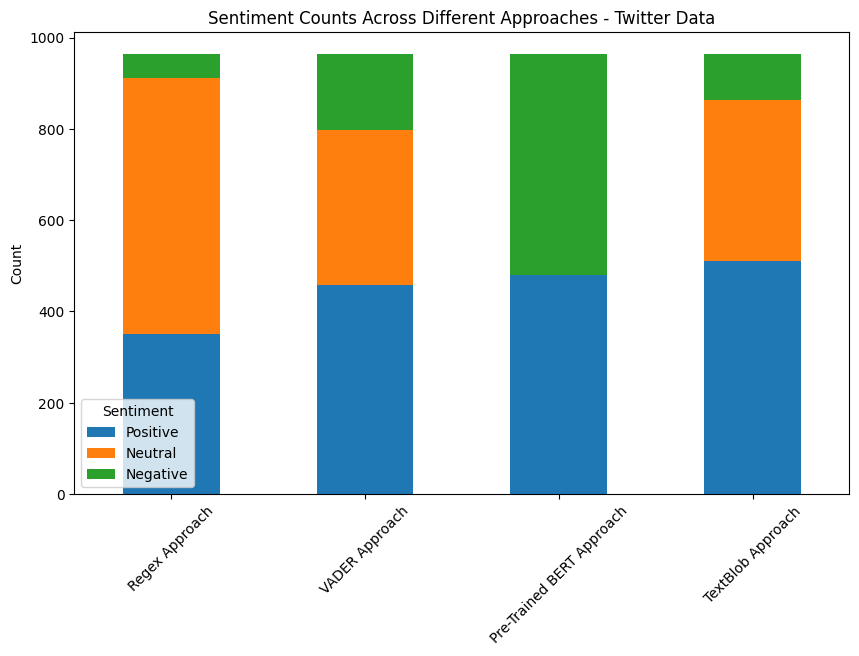

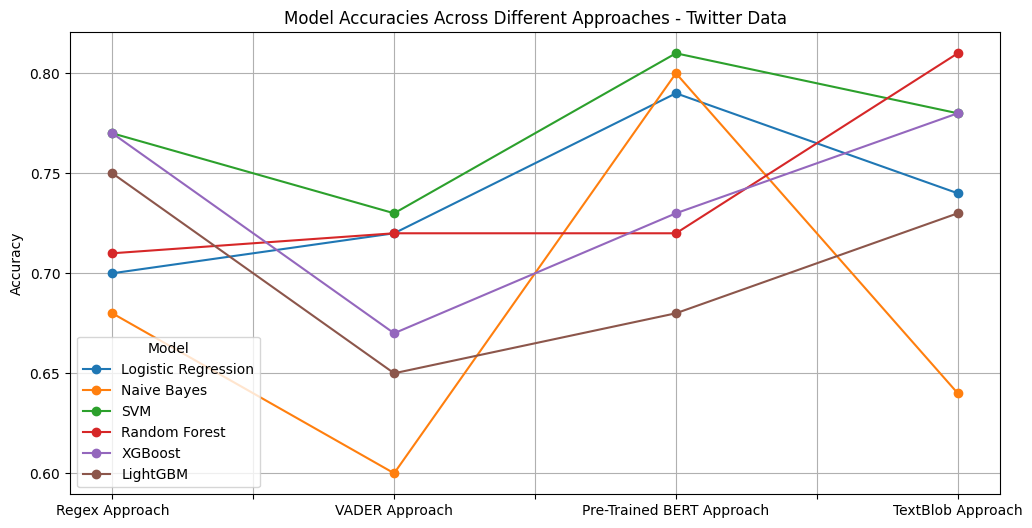

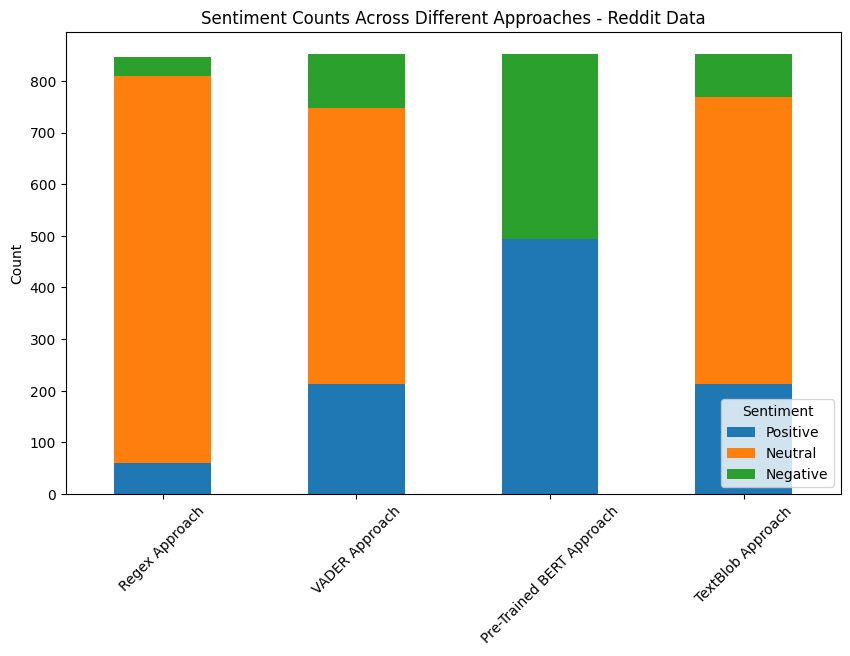

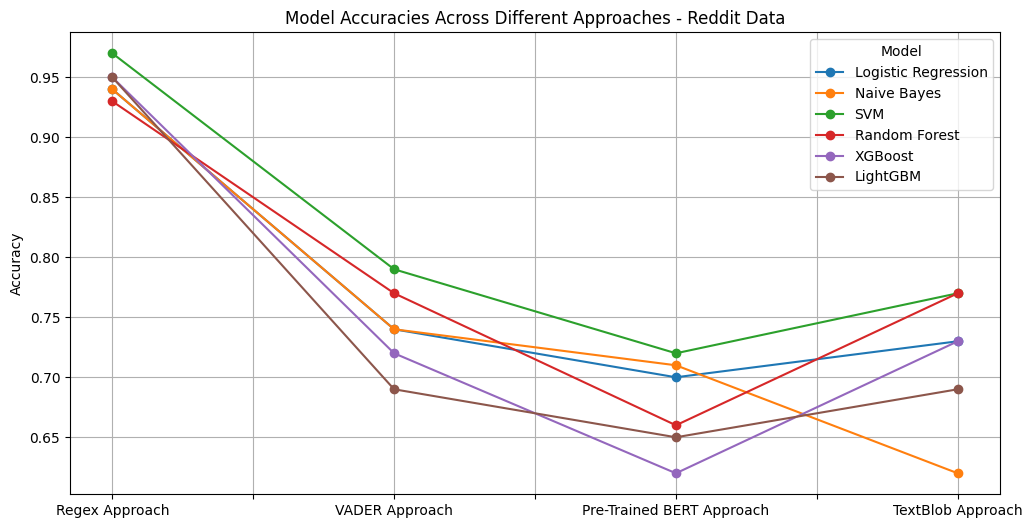

In [45]:
# Example sentiment count data for four cases
# Replace these with actual counts from your data
sentiment_counts = {
    "Regex Approach": {"Positive": 351, "Neutral": 560, "Negative": 53},
    "VADER Approach": {"Positive": 458, "Neutral": 339, "Negative": 167},
    "Pre-Trained BERT Approach": {"Positive": 479, "Neutral": 0, "Negative": 485},
    "TextBlob Approach": {"Positive": 510, "Neutral": 353, "Negative": 101},
}

# Convert to a DataFrame
sentiment_df = pd.DataFrame(sentiment_counts).T

# Plot sentiment counts
sentiment_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Sentiment Counts Across Different Approaches - Twitter Data")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)  # Set x-axis labels angle
plt.show()

# Example accuracy data for models across four cases
# Replace these with actual accuracies from your evaluations
model_accuracies = {
    "Logistic Regression": [0.70, 0.72, 0.79, 0.74],
    "Naive Bayes": [0.68, 0.60, 0.80, 0.64],
    "SVM": [0.77, 0.73, 0.81, 0.78],
    "Random Forest": [0.71, 0.72, 0.72, 0.81],
    "XGBoost": [0.77, 0.67, 0.73, 0.78],
    "LightGBM": [0.75, 0.65, 0.68, 0.73],
}

# Convert to a DataFrame
accuracy_df = pd.DataFrame(model_accuracies, index=["Regex Approach", "VADER Approach", "Pre-Trained BERT Approach", "TextBlob Approach"])

# Plot model accuracies
accuracy_df.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Model Accuracies Across Different Approaches - Twitter Data")
plt.ylabel("Accuracy")
plt.legend(title="Model")
plt.grid()
plt.show()

# Example sentiment count data for four cases
# Replace these with actual counts from your data
sentiment_counts = {
    "Regex Approach": {"Positive": 60, "Neutral": 750, "Negative": 36},
    "VADER Approach": {"Positive": 214, "Neutral": 533, "Negative": 105},
    "Pre-Trained BERT Approach": {"Positive": 494, "Neutral": 0, "Negative": 358},
    "TextBlob Approach": {"Positive": 214, "Neutral": 555, "Negative": 83},
}

# Convert to a DataFrame
sentiment_df = pd.DataFrame(sentiment_counts).T

# Plot sentiment counts
sentiment_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Sentiment Counts Across Different Approaches - Reddit Data")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)  # Set x-axis labels angle
plt.show()

# Example accuracy data for models across four cases
# Replace these with actual accuracies from your evaluations
model_accuracies = {
    "Logistic Regression": [0.94, 0.74, 0.70, 0.73],
    "Naive Bayes": [0.94, 0.74, 0.71, 0.62],
    "SVM": [0.97, 0.79, 0.72, 0.77],
    "Random Forest": [0.93, 0.77, 0.66, 0.77],
    "XGBoost": [0.95, 0.72, 0.62, 0.73],
    "LightGBM": [0.95, 0.69, 0.65, 0.69],
}

# Convert to a DataFrame
accuracy_df = pd.DataFrame(model_accuracies, index=["Regex Approach", "VADER Approach", "Pre-Trained BERT Approach", "TextBlob Approach"])

# Plot model accuracies
accuracy_df.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Model Accuracies Across Different Approaches - Reddit Data")
plt.ylabel("Accuracy")
plt.legend(title="Model")
plt.grid()
plt.show()
